In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import array
from scipy.io import savemat

In [71]:
import scipy.io
orig = np.fromfile('nu.bin', dtype=np.float64).reshape(100,100).T
fz = np.fromfile('fz.bin', dtype=np.float64).reshape(100,100).T
z = np.fromfile('z.bin', dtype=np.float64).reshape(100,100).T

In [72]:
patch_shape

(9409, 4, 4)

###  Разбитие на патчи и ksvd

In [73]:
import argparse
import numpy as np
from skimage import io, util
from sklearn.feature_extraction import image
from sklearn import preprocessing
from ksvd import ApproximateKSVD




def _ksvd(img):
    global patch_shape
    patch_size = (4, 4)
    patches = image.extract_patches_2d(img, patch_size)

    patch_shape = patches.shape
    print(patches.shape)  # (6, 10, 1, 512, 512, 3)

    signals = patches.reshape(patches.shape[0], -1)

    mean = np.mean(signals, axis=1)[:, np.newaxis]



    signals -= mean

    aksvd = ApproximateKSVD(n_components=20)

    D = aksvd.fit(signals[:10000])

    dictionary = D.components_

    A = aksvd.transform(signals)




    weights  = (A!=0).sum(axis=0)/(A!=0).sum()

    delta =5
    weights_matrix = np.diag(weights*delta+1)

    D_prime = np.matmul(weights_matrix,dictionary)
    reduced = A.dot(D_prime) + mean



    reduced_img = image.reconstruct_from_patches_2d(
        reduced.reshape(patches.shape), img.shape)
    return(A, D_prime, reduced,reduced_img)

    

In [74]:
A,D_prime,reduced,reduced_img = _ksvd(fz)

_,_,_,reduced_img_z = _ksvd(z)

(9409, 4, 4)
(9409, 4, 4)


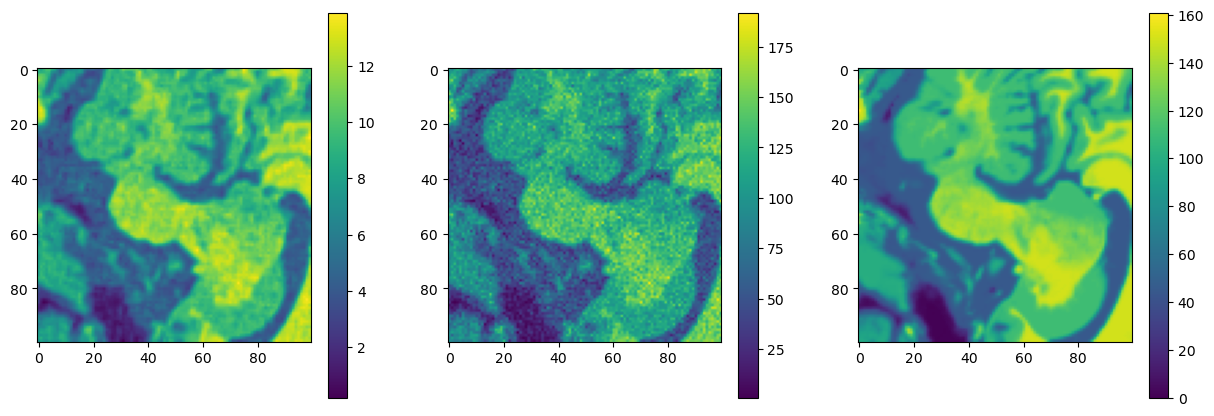

In [75]:
plt.figure(figsize =(15,5))

plt.subplot(131)
plt.imshow(reduced_img)
plt.colorbar()

plt.subplot(132)
plt.imshow(z)
plt.colorbar()


plt.subplot(133)
plt.imshow(orig)
plt.colorbar()

####  Здесь обозначение словарей (проще было список делать) как в статье I, M,CSS,SS

In [99]:
I = {}
for i,row in enumerate(reduced):
    I[i] = []
    for j in range(D_prime.shape[0]):
        if A[i,j]!=0:
            I[i].append(j)

    

In [77]:
M={}
for i in I:
    if len(I[i])==0:
        M[i] = None
    else:
        M[i]= abs(A[I[i]]).argmax()
        

In [78]:

import tqdm

In [79]:
CSS={}
for i in tqdm.tqdm(I):
    CSS[i] = []
    if len(I[i])==0:
        continue
    for j in M:
        if M[j] in I[i]:
            CSS[i].append(j)

100%|██████████████████████████████████████| 9409/9409 [00:17<00:00, 523.91it/s]


In [80]:
SS = {}
for i in tqdm.tqdm(CSS):
    SS[i] = [reduced[i]]
    if len(CSS[i])==0:
        continue
    for j in CSS[i]:
        #print(np.linalg.norm(reduced[i]-reduced[j])/np.linalg.norm(reduced[i]))
        if np.linalg.norm(reduced[i]-reduced[j])/np.linalg.norm(reduced[i])<0.1:
            SS[i].append(reduced[j])
    

100%|██████████████████████████████████████| 9409/9409 [00:30<00:00, 309.64it/s]


####  Здесь должен быть svd из схожих патчей, но лучше работает среднее

In [84]:
y_hat = reduced.copy()

for i in SS:
    u, s, vh = scipy.linalg.svd(SS[i], full_matrices=False)# Remove sigma values below threshold (250)

    s_cleaned = np.array([s[i] if i<20 else 0 for i in range(len(s))])# Calculate A' = U * Σ (cleaned) * V

    img_denoised = np.array(np.dot(u * s_cleaned, vh), dtype=int)
    y_hat[i] = np.mean(SS[i],axis=0)
    #y_hat[i] = np.mean(img_denoised,axis=0)

In [85]:
# for i in SS:
#     print(len(SS[i]))

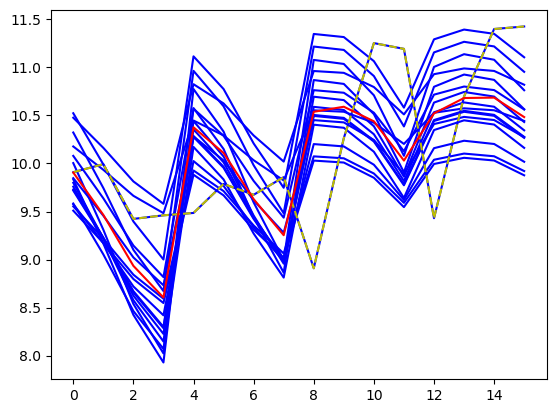

In [88]:
# for i in SS[1]:
#     plt.plot(i,color='r')
# plt.plot(reduced[1],'g--')
l= 40
for i in SS[l]:
    plt.plot(i,color='b')
plt.plot(reduced[l],'y--')
plt.plot(y_hat[l],'r')

In [89]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# def psnr(img1, img2):
#     mse = np.mean((img1 - img2) ** 2)
#     if mse == 0:
#         return 100
#     PIXEL_MAX = 255.0
#     return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [90]:
reduced_hat = image.reconstruct_from_patches_2d(y_hat.reshape(patch_shape), z.shape)

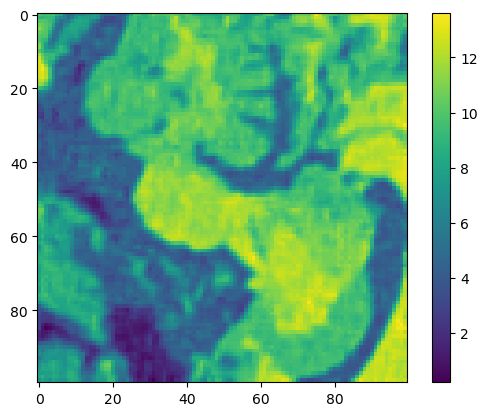

In [94]:
plt.imshow(reduced_hat)
plt.colorbar()

####  часть, которая задействует матлаб и делает обратный vst 

In [95]:
res_ksvd={} 
res_ksvd['fz'] = reduced_img 

savemat('transformed_ksvd.mat',res_ksvd)


res ={}
res['fz'] = reduced_hat
savemat('transformed.mat',res)

In [96]:
nu_hat_res= np.fromfile('nu_hat_res.bin', dtype=np.float64).reshape(100,100).T
nu_hat_ksvd= np.fromfile('nu_hat_ksvd.bin', dtype=np.float64).reshape(100,100).T

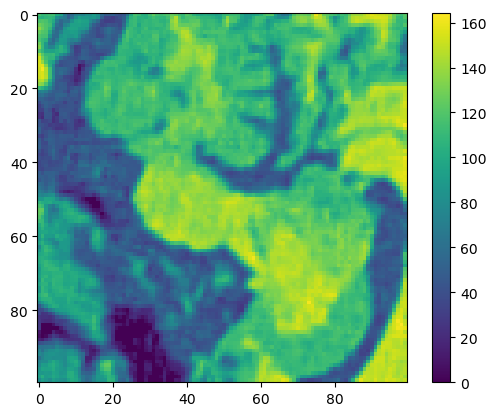

In [97]:
plt.imshow(nu_hat_res)
plt.colorbar()

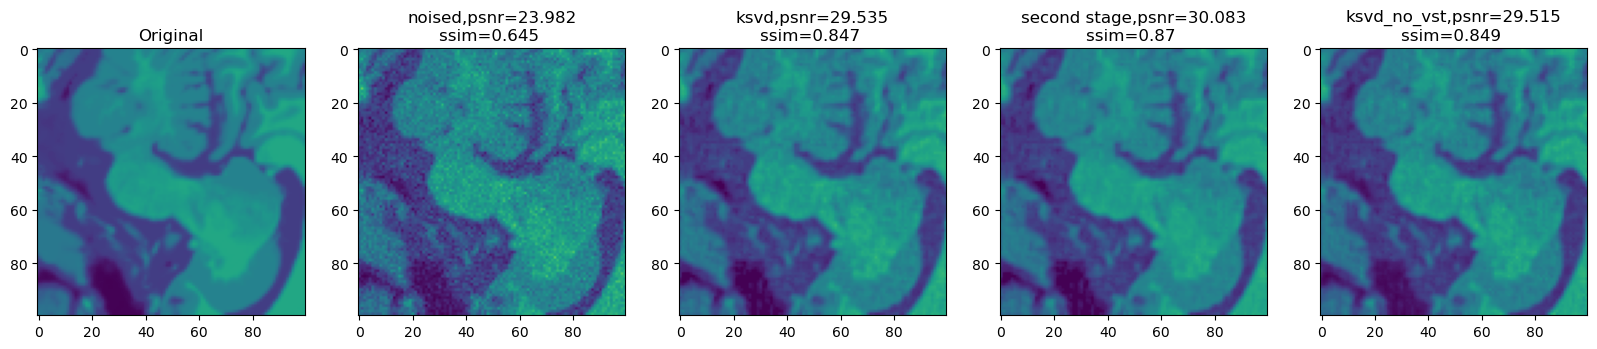

In [98]:
plt.figure(figsize =(20,7))

plt.subplot(151)
plt.title('Original')
plt.imshow(orig,vmax=250)




plt.subplot(152)
plt.title(f'noised,psnr={round(psnr(z,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(z,orig,data_range = 200),3)} ')

plt.imshow(z,vmax=250)



plt.subplot(153)

plt.title(f'ksvd,psnr={round(psnr(nu_hat_ksvd,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(nu_hat_ksvd,orig,data_range = 200),3)} ')
plt.imshow(nu_hat_ksvd,vmax=250)

plt.subplot(154)

plt.title(f'second stage,psnr={round(psnr(nu_hat_res,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(nu_hat_res,orig,data_range = 200),3)} ')

plt.imshow(nu_hat_res,vmax=250)



plt.subplot(155)

plt.title(f'ksvd_no_vst,psnr={round(psnr(reduced_img_z,orig,data_range = 200),3)}\n'+ 
          f'ssim={round(ssim(reduced_img_z,orig,data_range = 200),3)} ')

plt.imshow(reduced_img_z,vmax=250)
